# Explainability of Vision Transformer (ViT) on CIFAR-10

**Overview:**

In this notebook we evaluate the explainability of Vision Transformer (ViT-B) model on the CIFAR-10 dataset. We use multiple explanation methods including Grad-CAM, Grad-CAM++, Integrated Gradients and Attention Rollout.

**Architecture Choices**:

Apart from CNNs, transformer-based models were chosen because their self-attention mechanism captures long-range dependencies and provides interpretable attention maps.
Using the Base variant ensures sufficient model capacity to learn any complex patterns present in the full CIFAR-10 dataset.


In [ ]:
!pip install torch torchvision tqdm grad-cam captum


**Model Setup and Fine-Tuning**:

CIFAR-10 dataset was used for evaluation. The 32x32 images were resized to 244x244 to match the model's input requirements.
The model was inititalized with pre-defined weights, and was fine tuned on the entire dataset for 2 epochs to achieve an accuracy of 93.2%

In [ ]:
# ============================
# Vision Transformer on CIFAR-10
# ============================

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
from torchvision.models import vit_b_16

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# ----------------------------
# Model Wrapper
# ----------------------------
class ViTWrapper(nn.Module):
    def __init__(self, num_classes=10, pretrained=True):
        super(ViTWrapper, self).__init__()
        self.vit = vit_b_16(pretrained=pretrained)
        self.vit.heads.head = nn.Linear(self.vit.heads.head.in_features, num_classes)

    def forward(self, x):
        return self.vit(x)

model = ViTWrapper(num_classes=10, pretrained=True).to(device)
print("Model initialized.")

# ----------------------------
# CIFAR-10 Dataset
# ----------------------------
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

# ----------------------------
# Loss & Optimizer
# ----------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)


Using device: cuda


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:01<00:00, 195MB/s]


Model initialized.


100%|██████████| 170M/170M [00:04<00:00, 37.1MB/s]


In [ ]:
# ----------------------------
# Training Loop
# ----------------------------
num_epochs = 2
best_acc = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=False)
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    # ------------------------
    # Validation
    # ------------------------
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {running_loss/len(train_loader):.4f} | Val Acc: {acc:.2f}%")

    # Save best model
    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), "vit_cifar10_best.pth")

print("Training complete. Best Validation Accuracy: {:.2f}%".format(best_acc))

# ----------------------------
# Final Evaluation
# ----------------------------
model.load_state_dict(torch.load("vit_cifar10_best.pth"))
model.eval()

correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

final_acc = 100 * correct / total
print(f"Final Test Accuracy: {final_acc:.2f}%")

In [ ]:
checkpoint_path = "vit_cifar10_best.pth"

model = ViTWrapper(num_classes=10, pretrained=True).to(device)

# Case 1: If you saved only model.state_dict()
state_dict = torch.load(checkpoint_path, map_location=device)
try:
    model.load_state_dict(state_dict)
except RuntimeError:
    # Case 2: If you saved full dict with optimizer, etc.
    model.load_state_dict(state_dict["model_state_dict"])

model.eval()

ViTWrapper(
  (vit): VisionTransformer(
    (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=3072, out_features=768, bias=True)
            (4): Dropout(p=0.0, inplace=False)
          )
        )
        (encoder_layer_1): EncoderBlock(
          (ln_1): LayerN

## Integrated Gradients: Visualizing model attention

**Concepts:**

Integrated Gradients captures pixel-wise contribution by accumulating gradients along a path from a baseline (usually a zero image) to the actual input.

**Purpose:**

Used to quantify pixel-level contrbution, providing a fine-grained understanding of sensitivity.

**Quick references:**

Sundararajan et al., Axiomatic Attribution for Deep Networks (ICML 2017).

Captum (PyTorch) — Official interpretability library used for the IG implementation.

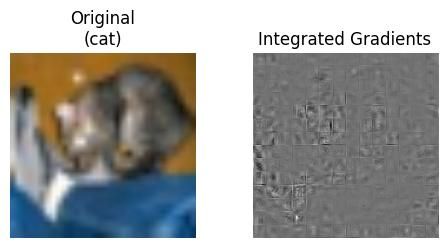

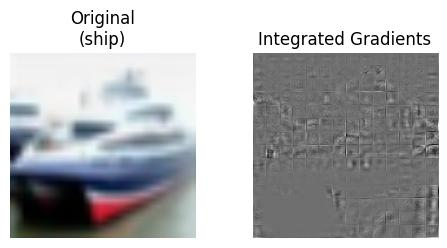

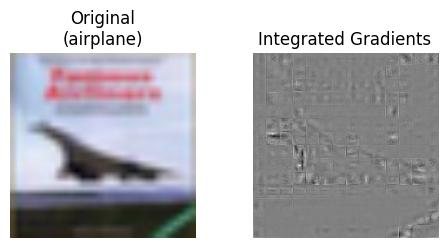

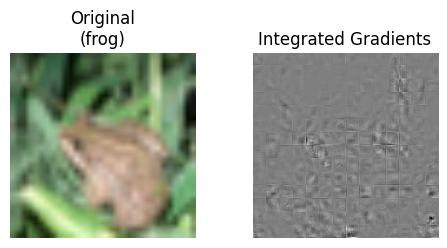

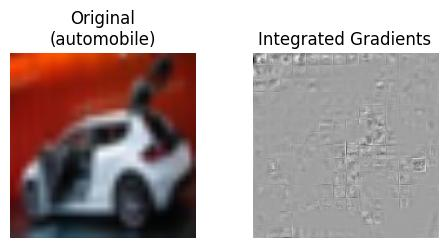

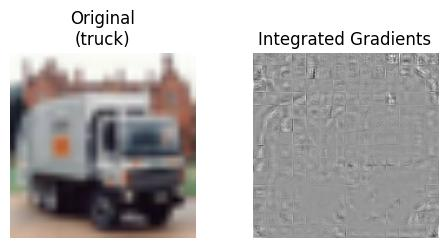

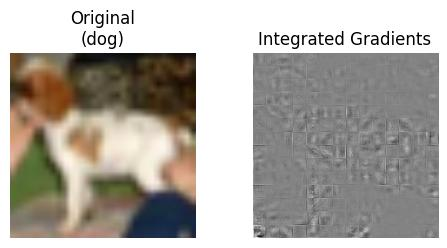

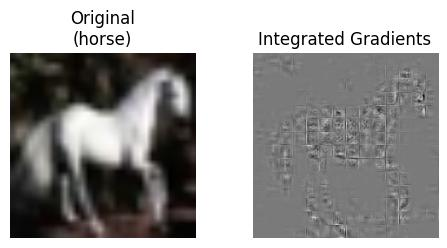

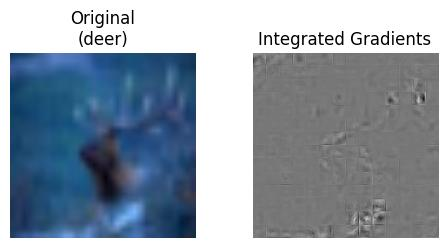

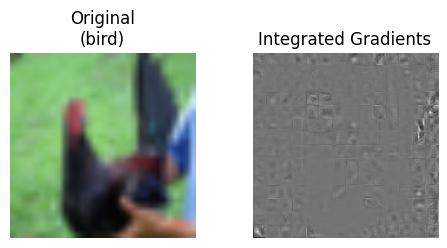

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from captum.attr import IntegratedGradients
from torchvision.models import vit_b_16

# ---------------------------
# Setup
# ---------------------------

# CIFAR-10 class names
cifar10_classes = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

# ---------------------------
# Select one image per class
# ---------------------------
selected_indices = {}
for idx, (img, label) in enumerate(test_dataset):
    if label not in selected_indices:
        selected_indices[label] = idx
    if len(selected_indices) == 10:
        break

# ---------------------------
# Integrated Gradients setup
# ---------------------------
ig = IntegratedGradients(model)
baseline = torch.zeros(1, 3, 224, 224).to(device)

# ---------------------------
# Visualization function
# ---------------------------
def visualize_ig(image_tensor, attr_tensor, label_idx):
    img = image_tensor.squeeze().permute(1,2,0).cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)

    # Sum over channels for attribution heatmap
    attr_sum = attr_tensor.squeeze().sum(dim=0).detach().cpu().numpy()
    attr_sum = (attr_sum - attr_sum.min()) / (attr_sum.max() - attr_sum.min() + 1e-8)

    plt.figure(figsize=(5, 2.5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(f"Original\n({cifar10_classes[label_idx]})")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(attr_sum, cmap="gray")
    plt.title("Integrated Gradients")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# ---------------------------
# Generate IG for one image per class
# ---------------------------
for cls, idx in selected_indices.items():
    img, label = test_dataset[idx]
    input_tensor = img.unsqueeze(0).to(device)

    with torch.no_grad():
        pred_class = model(input_tensor).argmax(dim=1).item()

    attr = ig.attribute(input_tensor, baseline, target=pred_class)
    visualize_ig(img, attr, label)


In [ ]:
from captum.attr import IntegratedGradients

ig = IntegratedGradients(model)


In [ ]:
from captum.attr import IntegratedGradients
import torch

# Initialize IG
ig = IntegratedGradients(model)
baseline = torch.zeros(1, 3, 224, 224).to(device)

# Precompute IG attributions for 10 images per class
attributions_dict = {}

num_per_class = 10
for cls_num in range(10):
    class_indices = [i for i, label in enumerate(test_dataset.targets) if label == cls_num][:num_per_class]

    for idx in class_indices:
        img, label = test_dataset[idx]
        input_tensor = img.unsqueeze(0).to(device)

        # Get prediction (for target)
        with torch.no_grad():
            output = model(input_tensor)
            pred_class = output.argmax(dim=1).item()

        # Compute IG
        attr, _ = ig.attribute(input_tensor, baseline, target=pred_class, return_convergence_delta=True)
        attributions_dict[idx] = attr.squeeze().detach().cpu()



## Insertion & Deletion Curves

**Concept**:

Insertion measures how the model's confidence rises as the important pixels are added back. Deletion measures how the model's confidence falls as those pixels are removed.

**Purpose**:

 Used to evaluate the **faithfulness** of the explanations i.e. whether the highlighted regions truly influence the model's predictions or not.


In [ ]:
# --- Insertion / Deletion Evaluation for ViT ---
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt


def patch_deletion_insertion_fast(model, input_img, attribution, patch_size=16, steps=20, device=device):
    """
    Patch-based Deletion & Insertion for ViT
    - input_img   : [1,3,H,W]
    - attribution : [1,3,H,W] (e.g., Integrated Gradients)
    - patch_size  : ViT patch size
    - steps       : number of deletion/insertion steps
    """
    model.eval()
    input_img = input_img.to(device)
    attr = attribution.clone().to(device)

    # Collapse channels for scalar importance
    if attr.size(1) > 1:
        attr = attr.sum(dim=1, keepdim=True)

    _, _, H, W = attr.shape
    n_patches_h = H // patch_size
    n_patches_w = W // patch_size

    # Compute patch-level attribution importance
    patch_attr = torch.zeros((n_patches_h, n_patches_w), device=device)
    for i in range(n_patches_h):
        for j in range(n_patches_w):
            patch = attr[:, :, i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size]
            patch_attr[i, j] = patch.sum()

    # Flatten & sort by importance
    patch_attr_flat = patch_attr.view(-1)
    sorted_indices = torch.argsort(patch_attr_flat, descending=True)
    total_patches = len(sorted_indices)
    patches_per_step = max(1, total_patches // steps)

    deletion_scores, insertion_scores = [], []

    # --- Deletion ---
    temp_img = input_img.clone()
    for step in range(steps):
        start, end = step * patches_per_step, min(total_patches, (step+1)*patches_per_step)
        for idx in sorted_indices[start:end]:
            r, c = divmod(idx.item(), n_patches_w)
            temp_img[:, :, r*patch_size:(r+1)*patch_size, c*patch_size:(c+1)*patch_size] = 0
        out = model(temp_img)
        conf = F.softmax(out, dim=1)[0].max().item()
        deletion_scores.append(conf)

    # --- Insertion ---
    temp_img = torch.zeros_like(input_img)
    for step in range(steps):
        start, end = step * patches_per_step, min(total_patches, (step+1)*patches_per_step)
        for idx in sorted_indices[start:end]:
            r, c = divmod(idx.item(), n_patches_w)
            temp_img[:, :, r*patch_size:(r+1)*patch_size, c*patch_size:(c+1)*patch_size] = \
                input_img[:, :, r*patch_size:(r+1)*patch_size, c*patch_size:(c+1)*patch_size]
        out = model(temp_img)
        conf = F.softmax(out, dim=1)[0].max().item()
        insertion_scores.append(conf)

    return deletion_scores, insertion_scores


In [ ]:
# Prepare containers
class_deletion = {i: [] for i in range(10)}
class_insertion = {i: [] for i in range(10)}

# Evaluate
for cls_num in range(10):
    class_indices = [i for i, label in enumerate(test_dataset.targets) if label == cls_num][:10]

    for idx in class_indices:
        img, label = test_dataset[idx]
        input_img = img.unsqueeze(0).to(device)

        # Use your saved IG attributions here
        attribution = attributions_dict[idx].unsqueeze(0).to(device)

        del_scores, ins_scores = patch_deletion_insertion_fast(model, input_img, attribution)

        class_deletion[cls_num].append(del_scores)
        class_insertion[cls_num].append(ins_scores)

# Compute average curves
avg_class_deletion = {k: np.mean(v, axis=0) for k, v in class_deletion.items()}
avg_class_insertion = {k: np.mean(v, axis=0) for k, v in class_insertion.items()}


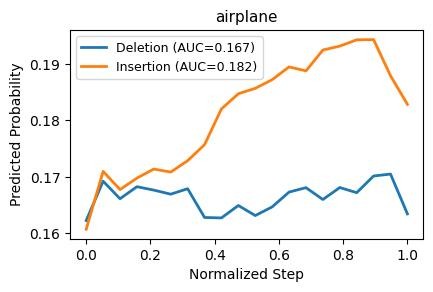

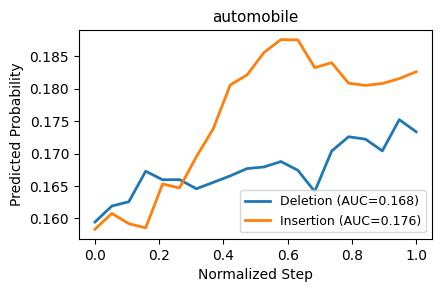

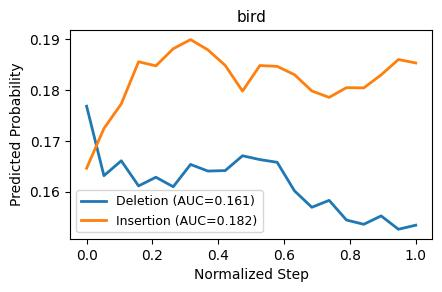

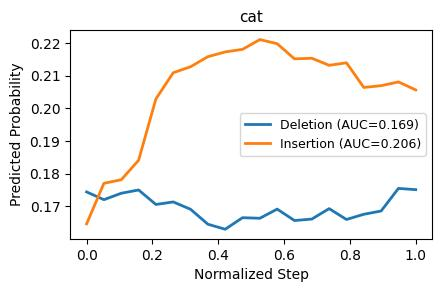

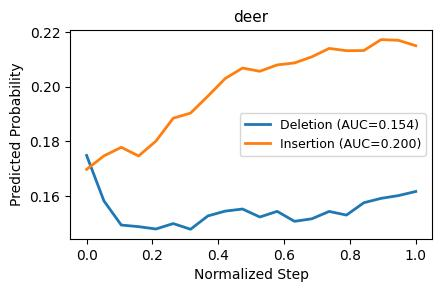

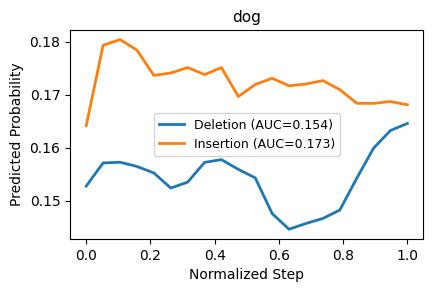

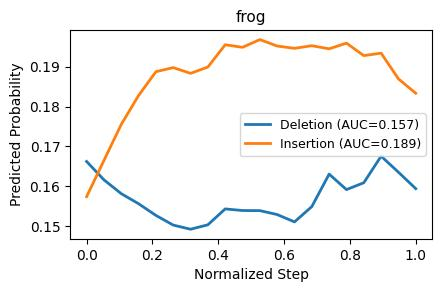

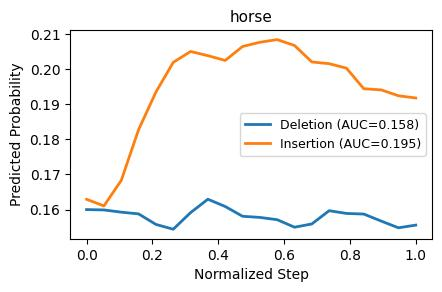

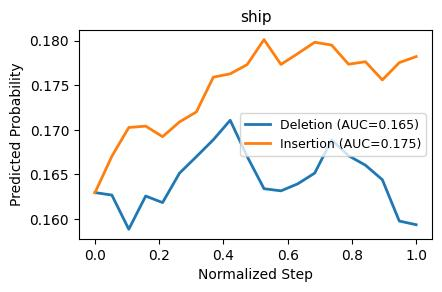

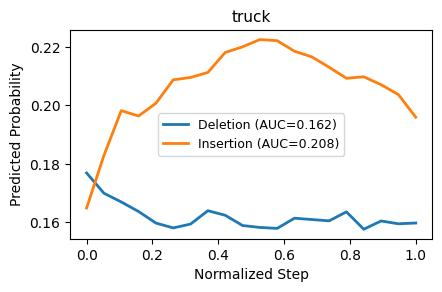

In [ ]:
from sklearn.metrics import auc
import numpy as np
import matplotlib.pyplot as plt

cifar10_classes = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

for cls_num in range(10):
    deletion_y = avg_class_deletion[cls_num]
    insertion_y = avg_class_insertion[cls_num]
    x = np.linspace(0, 1, len(deletion_y))  # normalized steps

    # Compute AUCs
    auc_del = auc(x, deletion_y)
    auc_ins = auc(x, insertion_y)

    plt.figure(figsize=(4.5, 3))
    plt.plot(x, deletion_y, label=f'Deletion (AUC={auc_del:.3f})', linewidth=2)
    plt.plot(x, insertion_y, label=f'Insertion (AUC={auc_ins:.3f})', linewidth=2)

    plt.xlabel('Normalized Step', fontsize=10)
    plt.ylabel('Predicted Probability', fontsize=10)
    plt.title(f'{cifar10_classes[cls_num]}', fontsize=11)
    plt.legend(fontsize=9)
    plt.tight_layout(pad=1)
    plt.show()


In [ ]:
from sklearn.metrics import auc
import numpy as np

cifar10_classes = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

auc_deletion_scores = []
auc_insertion_scores = []

for cls_num in range(10):
    deletion_y = avg_class_deletion[cls_num]
    insertion_y = avg_class_insertion[cls_num]
    x = np.linspace(0, 1, len(deletion_y))  # normalized steps

    # Compute AUCs
    auc_del = auc(x, deletion_y)
    auc_ins = auc(x, insertion_y)
    auc_deletion_scores.append(auc_del)
    auc_insertion_scores.append(auc_ins)

# Print AUC summary
print("Class-wise AUC Scores:")
print("-" * 45)
for cls, del_auc, ins_auc in zip(cifar10_classes, auc_deletion_scores, auc_insertion_scores):
    print(f"{cls:10s} | Deletion AUC: {del_auc:.4f} | Insertion AUC: {ins_auc:.4f}")

print("-" * 45)
print(f"Mean Deletion AUC : {np.mean(auc_deletion_scores):.4f}")
print(f"Mean Insertion AUC: {np.mean(auc_insertion_scores):.4f}")


Class-wise AUC Scores:
---------------------------------------------
airplane   | Deletion AUC: 0.1666 | Insertion AUC: 0.1816
automobile | Deletion AUC: 0.1676 | Insertion AUC: 0.1756
bird       | Deletion AUC: 0.1612 | Insertion AUC: 0.1824
cat        | Deletion AUC: 0.1692 | Insertion AUC: 0.2064
deer       | Deletion AUC: 0.1540 | Insertion AUC: 0.1996
dog        | Deletion AUC: 0.1540 | Insertion AUC: 0.1728
frog       | Deletion AUC: 0.1566 | Insertion AUC: 0.1888
horse      | Deletion AUC: 0.1580 | Insertion AUC: 0.1953
ship       | Deletion AUC: 0.1646 | Insertion AUC: 0.1749
truck      | Deletion AUC: 0.1617 | Insertion AUC: 0.2079
---------------------------------------------
Mean Deletion AUC : 0.1614
Mean Insertion AUC: 0.1885


**Observations**:

Both the curves and the AUCs are intuitive: Insertion curve is increasing while the Deletion curve is decreasing, and the Insertion AUC is higher than Deletion AUC. This indicates that the highlighted regions positively influences the model's predictions.

## Entropy & Sparsity
**Concept**:

Entropy measures how spread-out the attention is on a saliency map, while Sparsity quantifies how concentrated it is (i.e. how much of the total area actually carries **meaningful activation**)

For highly focused attributions, the Entropy should be lower while the Sparsity should be higher.


**Purpose**:

Used to quantify how focused or diffused the model's visual explanations are across all the classes.


In [ ]:
import numpy as np
import torch
from scipy.stats import entropy

def compute_entropy_sparsity(attr_tensor):
    # Handle shape
    if attr_tensor.ndim == 4:
        attr_tensor = attr_tensor.squeeze(0)
    elif attr_tensor.ndim != 3:
        raise ValueError(f"Unexpected tensor shape: {attr_tensor.shape}")

    # Combine across channels
    attr = attr_tensor.abs().sum(dim=0).cpu().numpy()
    attr = np.maximum(attr, 0)

    # Normalize
    total = attr.sum()
    if total == 0:
        return 0.0, 1.0
    attr /= total

    # ---------- ENTROPY ----------
    ent = entropy(attr.flatten() + 1e-10)

    # ---------- SPARSITY ----------
    # Sparsity as normalized L1/L2 ratio — captures spread/concentration
    l1 = np.sum(np.abs(attr))
    l2 = np.sqrt(np.sum(attr ** 2))
    sparsity = 1 - (l2 / (l1 + 1e-8))  # higher = more sparse

    sparsity = np.clip(sparsity, 0, 1)

    return ent, sparsity


# ---------- Evaluate for 10 images per class ----------
class_entropy = {i: [] for i in range(10)}
class_sparsity = {i: [] for i in range(10)}

for cls_num in range(10):
    class_indices = [i for i, label in enumerate(test_dataset.targets) if label == cls_num][:10]

    for idx in class_indices:
        if idx not in attributions_dict:
            continue
        attr = attributions_dict[idx]
        ent, sp = compute_entropy_sparsity(attr)
        class_entropy[cls_num].append(ent)
        class_sparsity[cls_num].append(sp)

# ---------- Average per class ----------
avg_entropy = {k: np.mean(v) if len(v) > 0 else 0 for k, v in class_entropy.items()}
avg_sparsity = {k: np.mean(v) if len(v) > 0 else 0 for k, v in class_sparsity.items()}

# ---------- Print results ----------
cifar10_classes = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

print("Class-wise Attribution Metrics (Entropy & Sparsity)")
print("-" * 60)
for cls, e, s in zip(cifar10_classes, avg_entropy.values(), avg_sparsity.values()):
    print(f"{cls:10s} | Entropy: {e:.4f} | Sparsity: {s:.4f}")
print("-" * 60)
print(f"Mean Entropy : {np.mean(list(avg_entropy.values())):.4f}")
print(f"Mean Sparsity: {np.mean(list(avg_sparsity.values())):.4f}")


Class-wise Attribution Metrics (Entropy & Sparsity)
------------------------------------------------------------
airplane   | Entropy: 10.3310 | Sparsity: 0.9928
automobile | Entropy: 10.3210 | Sparsity: 0.9929
bird       | Entropy: 10.2766 | Sparsity: 0.9926
cat        | Entropy: 10.3524 | Sparsity: 0.9930
deer       | Entropy: 10.4149 | Sparsity: 0.9934
dog        | Entropy: 10.4022 | Sparsity: 0.9934
frog       | Entropy: 10.3634 | Sparsity: 0.9930
horse      | Entropy: 10.3375 | Sparsity: 0.9931
ship       | Entropy: 10.3255 | Sparsity: 0.9929
truck      | Entropy: 10.3961 | Sparsity: 0.9932
------------------------------------------------------------
Mean Entropy : 10.3521
Mean Sparsity: 0.9930


**Observations**:

The high Sparsity suggests that Integrated Gradients distributed the attributions nearly across the entire image.


The high Entropy suggests that these attributions are unifromly spread and not overly concentrated in a few dominant regions.


Together, this suggests that the model's reasoning is holistic instead of being localized, which is typical for a transformer architecture, because their self-attention mechanism makes them rely on global contextual cues.

## Grad-CAM: Visualizing model attention

**Concept**:

Grad-CAM highlights the image regions that are most responsible for the model's decision by tracing class-specific gradients throught the final feature maps.

**Purpose**:

In our notebook, we use it to interpret spatial focus in the first LayerNorm layer of the final encoder block (`model.vit.encoder.layers[-1].ln_1`). This is the deepest feature extraction layer before the final classification head in ViT-B.


**Quick references**
- Selvaraju et al., *Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization* (2017).  
- `pytorch-grad-cam` (Jacob Gildenblat) — used for production-ready Grad-CAM utilities.



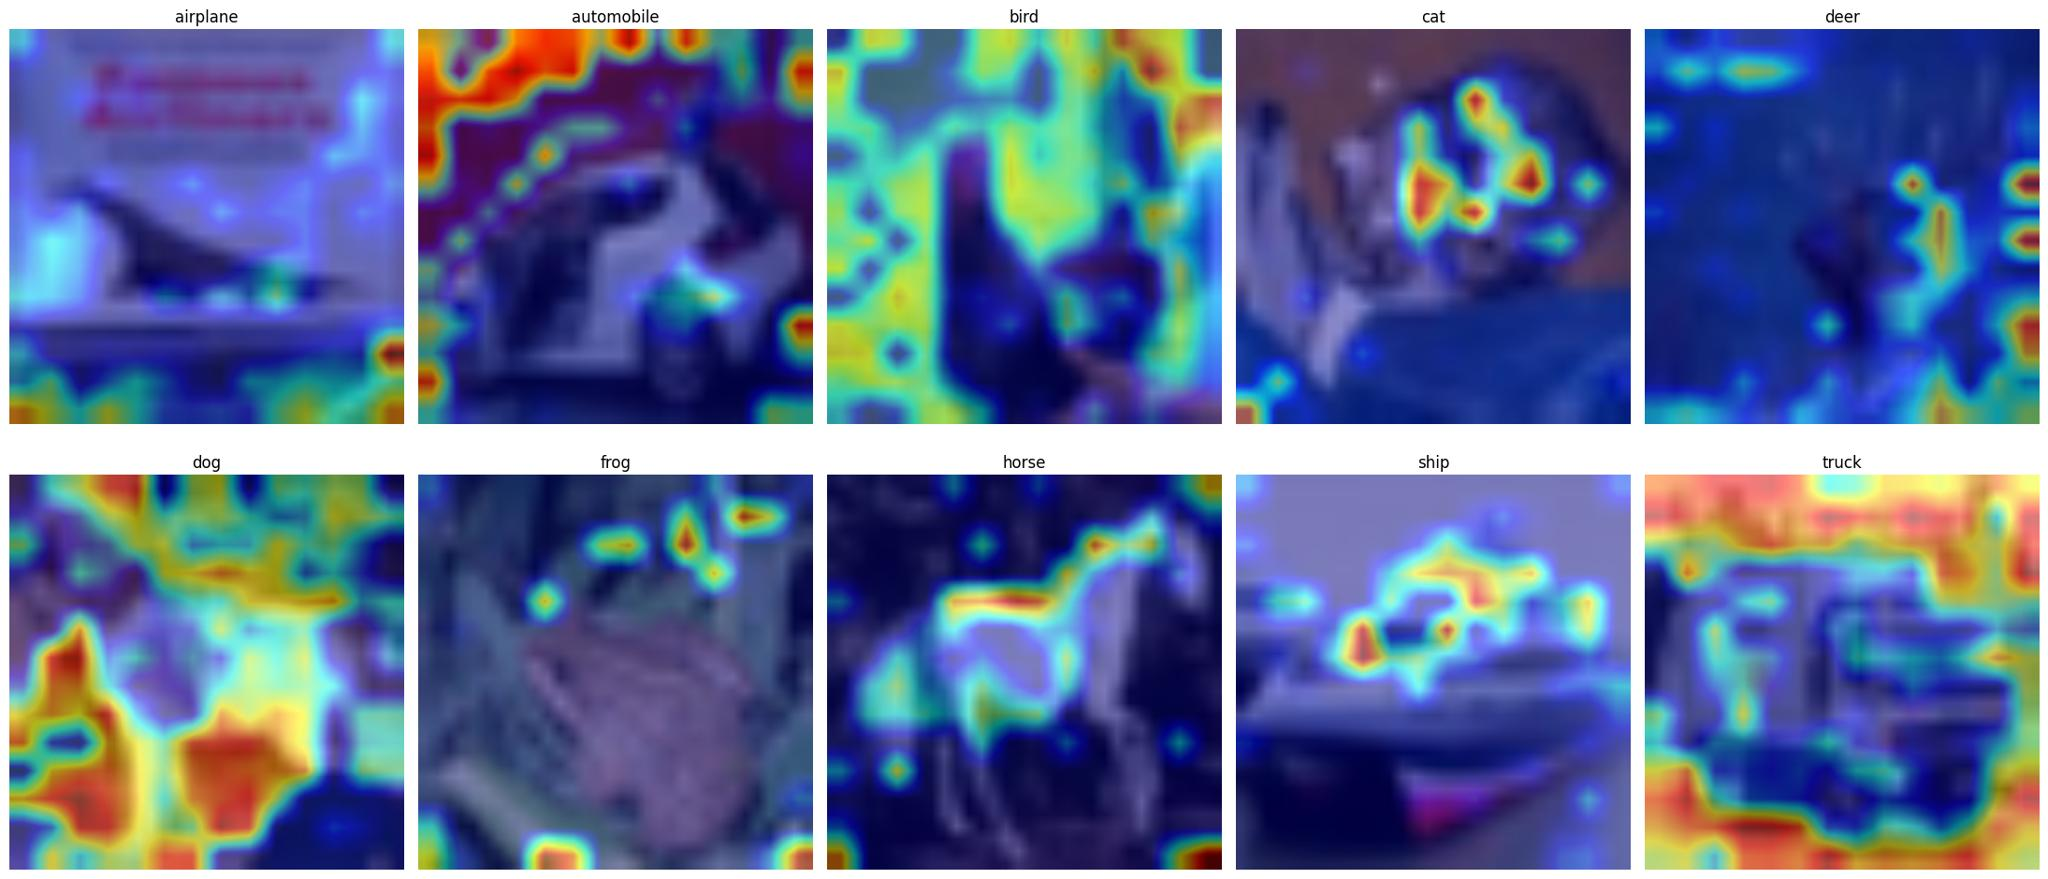

In [ ]:
import math
import torch
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt

model.eval()

cifar10_classes = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

# --- Reshape function for ViT ---
def reshape_transform(tensor):
    batch_size, num_tokens, hidden_dim = tensor.size()
    spatial_size = int(math.sqrt(num_tokens - 1))
    result = tensor[:, 1:, :].reshape(batch_size, spatial_size, spatial_size, hidden_dim)
    result = result.permute(0, 3, 1, 2)
    return result

# --- GradCAM setup ---
target_layers = [model.vit.encoder.layers[-1].ln_1]
cam = GradCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform)

# --- Map class index to name ---
idx_to_class = {v: k for k, v in test_dataset.class_to_idx.items()}

# --- One sample per class ---
sample_indices = []
for cls in range(10):
    idxs = [i for i, y in enumerate(test_dataset.targets) if y == cls]
    if idxs:
        sample_indices.append(idxs[0])

# --- Plot setup ---
plt.figure(figsize=(22, 10))
for i, idx in enumerate(sample_indices):
    input_tensor = test_dataset[idx][0].unsqueeze(0).to(device)
    target_class = test_dataset[idx][1]
    targets = [ClassifierOutputTarget(target_class)]

    # GradCAM heatmap
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

    # Normalize RGB image
    rgb_img = input_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())

    # Overlay CAM
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    plt.subplot(2, 5, i + 1)
    plt.imshow(visualization)
    plt.title(f"{cifar10_classes[target_class]}", fontsize=12)
    plt.axis('off')

plt.tight_layout()
plt.show()


**Observations**:

The heatmaps look very cluttered and chaotic, and there are a few reasons for this.

1.   Grad-CAM variants in general need clear gradient flow through spatial feature maps, but ViTs do not have spatial feature maps, they have patch tokens instead. When the patck tokens are diffuse, Grad-CAM ends up assigning nearly uniform weights and the visualization looks blank or faint.
Therefore, for cases with minimal activation, the model's confidence comes from global correlations and not any particular visual spot.
2.   When the model does localize strongly, Grad-CAM variants aggregates many attention heads and layers and often, the weights for several patches can become similar. This therefore can cause broadly saturated maps.




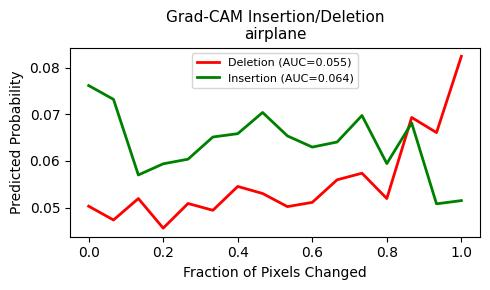

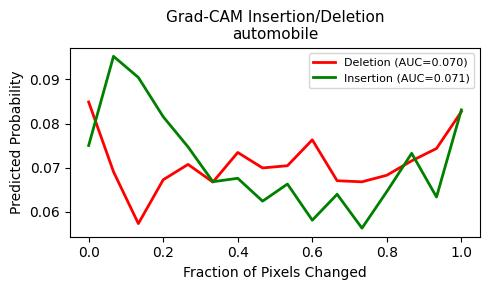

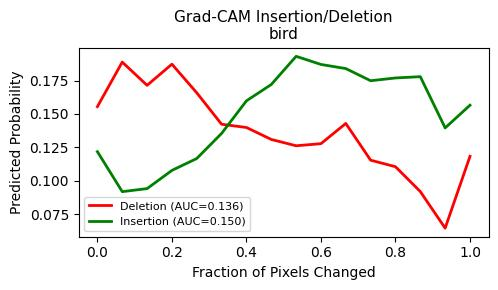

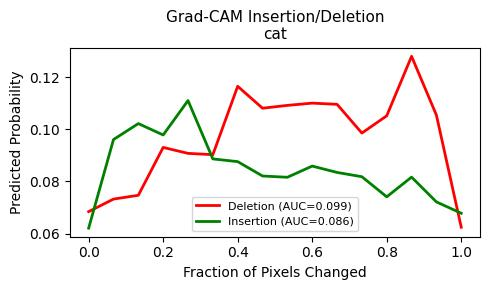

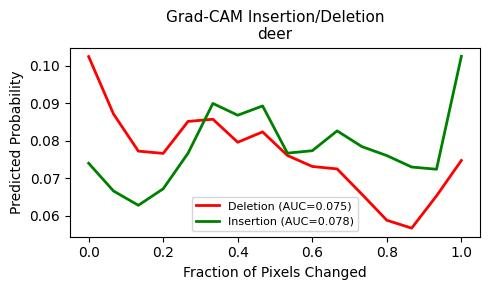

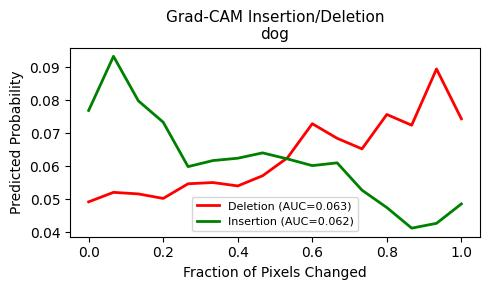

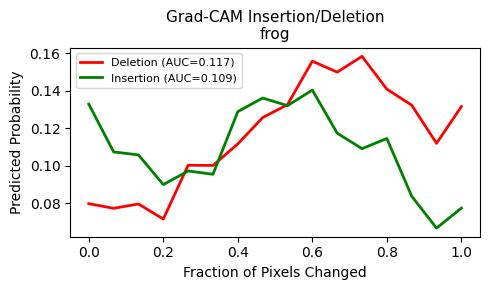

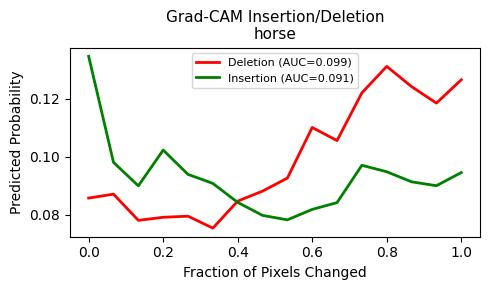

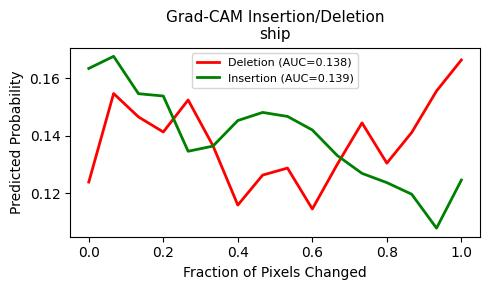

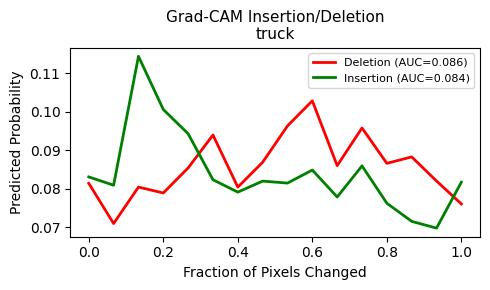


=== Grad-CAM AUC Summary ===
airplane        | Insertion AUC: 0.0637 | Deletion AUC: 0.0547
automobile      | Insertion AUC: 0.0709 | Deletion AUC: 0.0702
bird            | Insertion AUC: 0.1500 | Deletion AUC: 0.1362
cat             | Insertion AUC: 0.0861 | Deletion AUC: 0.0985
deer            | Insertion AUC: 0.0776 | Deletion AUC: 0.0754
dog             | Insertion AUC: 0.0617 | Deletion AUC: 0.0629
frog            | Insertion AUC: 0.1086 | Deletion AUC: 0.1169
horse           | Insertion AUC: 0.0915 | Deletion AUC: 0.0989
ship            | Insertion AUC: 0.1390 | Deletion AUC: 0.1376
truck           | Insertion AUC: 0.0843 | Deletion AUC: 0.0863

Mean Insertion AUC: 0.0933
Mean Deletion AUC:  0.0938
Overall Mean AUC:   0.0935


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device).eval()

cam = GradCAM(model=model, target_layers=target_layer)

class_names = test_dataset.classes
steps = 15  # reduce slightly for speed

def compute_insertion_deletion_vectorized(model, img_tensor, saliency, img_label, steps=15):
    C, H, W = img_tensor.shape
    img = img_tensor.unsqueeze(0).to(device)

    sal_flat = saliency.flatten()
    indices = np.argsort(-sal_flat)
    step_size = len(indices) // steps
    insertion_masks, deletion_masks = [], []

    for i in range(steps + 1):
        mask_ins = torch.zeros_like(img)
        mask_del = img.clone()

        if i > 0:
            idxs = indices[: i * step_size]
            ys = idxs // W
            xs = idxs % W
            mask_ins[0, :, ys, xs] = img[0, :, ys, xs]
            mask_del[0, :, ys, xs] = 0.0

        insertion_masks.append(mask_ins)
        deletion_masks.append(mask_del)

    insertion_masks = torch.cat(insertion_masks, dim=0)
    deletion_masks = torch.cat(deletion_masks, dim=0)

    with torch.no_grad():
        out_ins = torch.softmax(model(insertion_masks), dim=1)[:, img_label].cpu().numpy()
        out_del = torch.softmax(model(deletion_masks), dim=1)[:, img_label].cpu().numpy()

    return out_ins, out_del


# --- Select 3 images per class ---
images_per_class = {i: [] for i in range(10)}
for idx, lbl in enumerate(test_dataset.targets):
    if len(images_per_class[lbl]) < 3:
        img, _ = test_dataset[idx]
        images_per_class[lbl].append(img)
    if all(len(v) >= 3 for v in images_per_class.values()):
        break


# --- Track AUC values ---
all_auc_ins, all_auc_del = [], []

torch.no_grad()
for cls_idx, imgs in images_per_class.items():
    ins_curves, del_curves = [], []

    for img_tensor in imgs:
        input_tensor = img_tensor.unsqueeze(0).to(device)
        targets = [ClassifierOutputTarget(cls_idx)]
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

        H, W = img_tensor.shape[1], img_tensor.shape[2]
        saliency_upsampled = cv2.resize(grayscale_cam, (W, H))
        saliency_upsampled = (saliency_upsampled - saliency_upsampled.min()) / (saliency_upsampled.max() - saliency_upsampled.min() + 1e-8)

        ins, dele = compute_insertion_deletion_vectorized(model, img_tensor, saliency_upsampled, cls_idx, steps)
        ins_curves.append(ins)
        del_curves.append(dele)

    ins_mean = np.mean(ins_curves, axis=0)
    del_mean = np.mean(del_curves, axis=0)

    x = np.linspace(0, 1, steps + 1)
    auc_ins = np.trapz(ins_mean, x)
    auc_del = np.trapz(del_mean, x)

    all_auc_ins.append(auc_ins)
    all_auc_del.append(auc_del)

    plt.figure(figsize=(5, 3))
    plt.plot(x, del_mean, label=f'Deletion (AUC={auc_del:.3f})', color='red', linewidth=2)
    plt.plot(x, ins_mean, label=f'Insertion (AUC={auc_ins:.3f})', color='green', linewidth=2)
    plt.title(f"Grad-CAM Insertion/Deletion\n{class_names[cls_idx]}", fontsize=11)
    plt.xlabel("Fraction of Pixels Changed")
    plt.ylabel("Predicted Probability")
    plt.legend(fontsize=8)
    plt.tight_layout()
    plt.show()

# --- Print AUC summary ---
print("\n=== Grad-CAM AUC Summary ===")
for i, cls_name in enumerate(class_names):
    print(f"{cls_name:15s} | Insertion AUC: {all_auc_ins[i]:.4f} | Deletion AUC: {all_auc_del[i]:.4f}")

mean_ins = np.mean(all_auc_ins)
mean_del = np.mean(all_auc_del)
print(f"\nMean Insertion AUC: {mean_ins:.4f}")
print(f"Mean Deletion AUC:  {mean_del:.4f}")
print(f"Overall Mean AUC:   {(mean_ins + mean_del)/2:.4f}")


**Observations**:

The varying patterns in the Insertion and Deletion curves arise from the inherent mismatch between Grad-CAM’s assumption of localized, spatially coherent attributions and the ViT’s globally distributed attention mechanism. This clash results in non-uniform attribution structures across samples, leading to inconsistent confidence changes during pixel insertion and deletion.

In [ ]:
import torch
import numpy as np
import cv2
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# -------------------------------
# Setup
# -------------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device).eval()

# Define GradCAM
target_layer=[model.vit.encoder.layers[-1].ln_1]
cam = GradCAM(model=model, target_layers=target_layer)

class_names = test_dataset.classes


# -------------------------------
# Metric Computation Functions
# -------------------------------
def compute_entropy_sparsity(cam_map):
    """Compute entropy and sparsity of a normalized Grad-CAM heatmap."""
    cam_norm = cam_map / (cam_map.sum() + 1e-8)
    entropy = -(cam_norm * np.log(cam_norm + 1e-8)).sum()
    sparsity = 1.0 - (np.count_nonzero(cam_norm > 1e-5) / cam_norm.size)
    return entropy, sparsity


# -------------------------------
# Collect 10 images per class
# -------------------------------
images_per_class = {cls: [] for cls in class_names}

for idx in range(len(test_dataset)):
    img, lbl = test_dataset[idx]
    cls_name = class_names[lbl]
    if len(images_per_class[cls_name]) < 10:
        images_per_class[cls_name].append(img)
    if all(len(v) >= 10 for v in images_per_class.values()):
        break


# -------------------------------
# Compute metrics
# -------------------------------
metrics = {}

for cls_idx, (cls_name, imgs) in enumerate(images_per_class.items()):
    entropies, sparsities = [], []

    for img_tensor in imgs:
        input_tensor = img_tensor.unsqueeze(0).to(device)
        targets = [ClassifierOutputTarget(cls_idx)]
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

        # Normalize saliency map
        saliency = cv2.resize(grayscale_cam, (img_tensor.shape[2], img_tensor.shape[1]))
        saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min() + 1e-8)

        e, s = compute_entropy_sparsity(saliency)
        entropies.append(e)
        sparsities.append(s)

    metrics[cls_name] = {
        "entropy": np.mean(entropies),
        "sparsity": np.mean(sparsities)
    }


# -------------------------------
# Print results neatly
# -------------------------------
print("\n" + "="*42)
print(f"{'Class':<15s} | {'Entropy':>10s} | {'Sparsity':>10s}")
print("="*42)

all_entropies = []
all_sparsities = []

for cls, vals in metrics.items():
    print(f"{cls:<15s} | {vals['entropy']:.4f} | {vals['sparsity']:.4f}")
    all_entropies.append(vals['entropy'])
    all_sparsities.append(vals['sparsity'])

mean_entropy = np.mean(all_entropies)
mean_sparsity = np.mean(all_sparsities)

print("="*42)
print(f"{'Mean':<15s} | {mean_entropy:.4f} | {mean_sparsity:.4f}")
print("="*42)



Class           |    Entropy |   Sparsity
airplane        | 6.2627 | 0.6837
automobile      | 8.2162 | 0.7159
bird            | 8.0801 | 0.4485
cat             | 8.7968 | 0.4966
deer            | 6.2882 | 0.7716
dog             | 8.8149 | 0.5507
frog            | 10.5795 | 0.1935
horse           | 10.0969 | 0.4202
ship            | 7.8895 | 0.5836
truck           | 8.4037 | 0.6272
Mean            | 8.3429 | 0.5492


**Observations**:

The lower Entropy and Sparsity compared to IG indicates that Grad-CAM activates moderately broad but clearly defined regions. Therefore, the heatmaps produced by Grad-CAM are more localized than IG.

This suggests that Grad-CAM variants' visualizations in ViTs are object centric due to the method's localization mechanism, yet they have a moderately global spread due to the transformer's inherent global attention patterns.

## Grad-CAM++: Visualizing model attention

**Concept**:

Grad-CAM++ refines Grad-CAM by incorporating higher-order gradient information. This enhances localization and handling of multiple object instances.

**Purpose**:

Used to asses how finely the model distinguishes multiple features or parts within an image.

**Quick references**:

Chattopadhyay et al., Grad-CAM++: Improved Visual Explanations for Deep Convolutional Networks, WACV 2018.

Gildenblat, pytorch-grad-cam library — robust reference implementation.

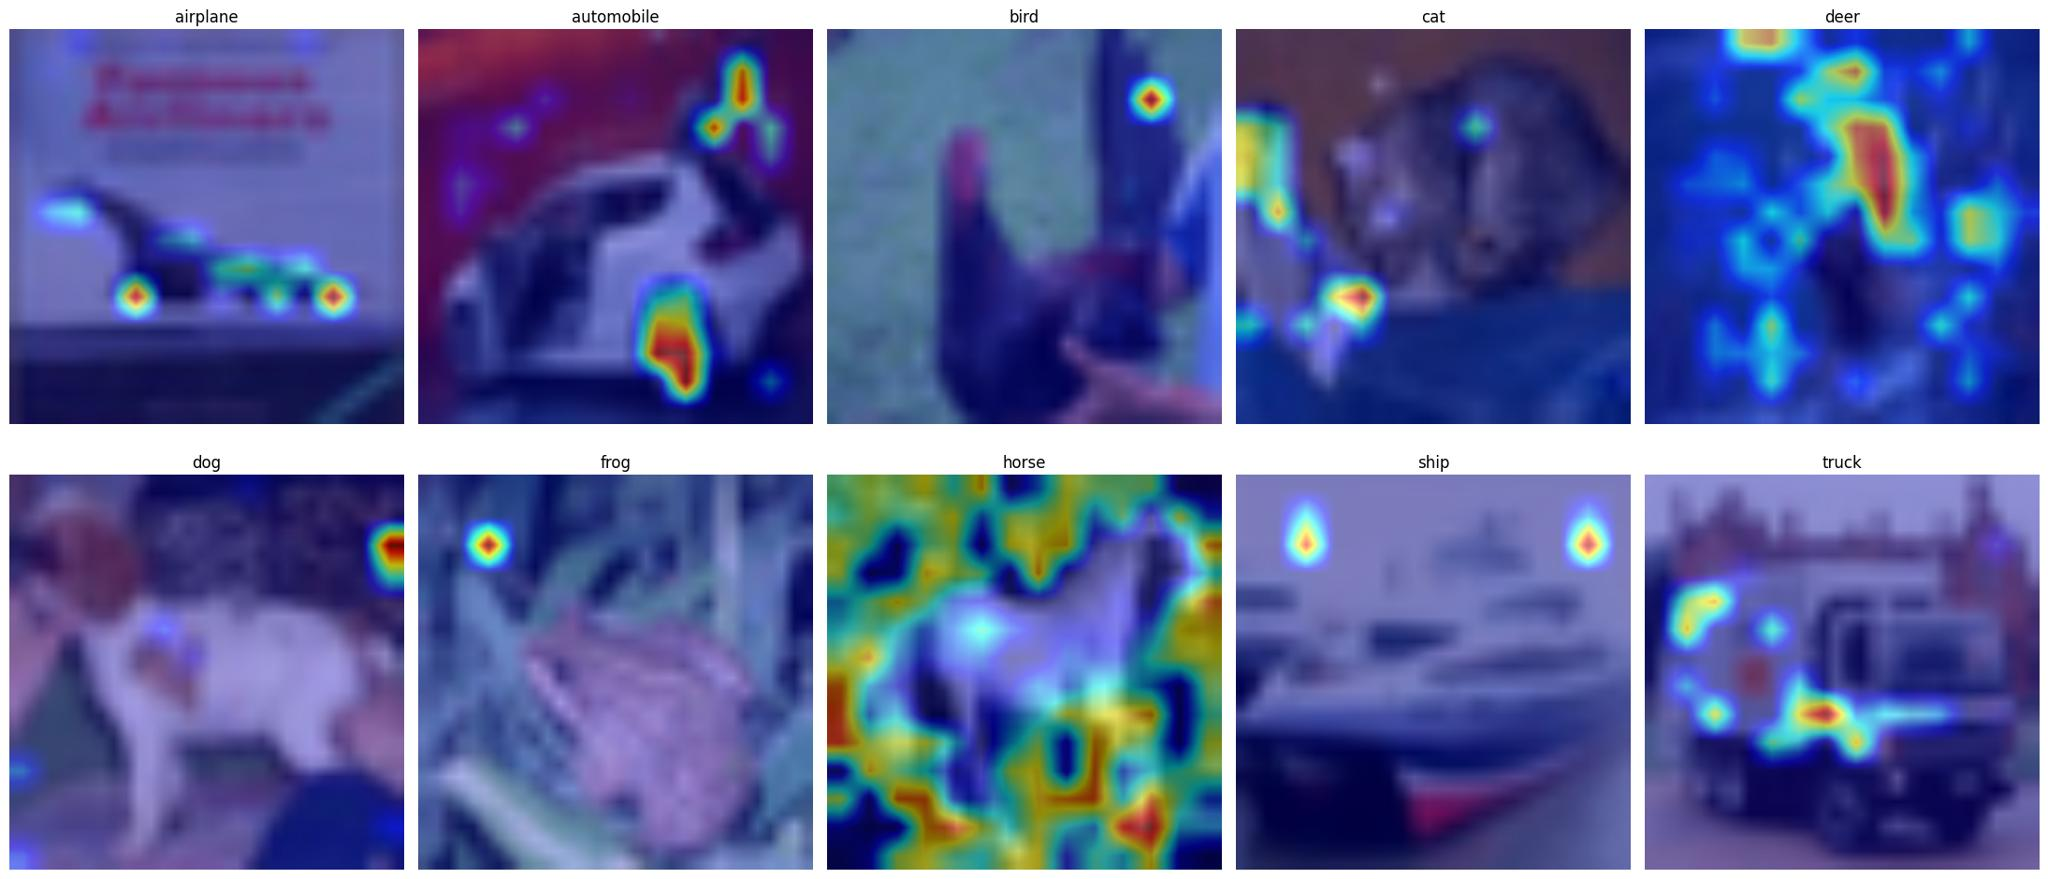

In [ ]:
import math
import torch
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt

# --- Evaluation mode ---
model.eval()

# --- CIFAR-10 classes ---
cifar10_classes = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

# --- Reshape function for ViT ---
def reshape_transform(tensor):
    batch_size, num_tokens, hidden_dim = tensor.size()
    spatial_size = int(math.sqrt(num_tokens - 1))
    result = tensor[:, 1:, :].reshape(batch_size, spatial_size, spatial_size, hidden_dim)
    result = result.permute(0, 3, 1, 2)
    return result

# --- GradCAM++ setup ---
target_layers = [model.vit.encoder.layers[-1].ln_1]
cam = GradCAMPlusPlus(model=model, target_layers=target_layers, reshape_transform=reshape_transform)

# --- Map class index to name ---
idx_to_class = {v: k for k, v in test_dataset.class_to_idx.items()}

# --- Select one sample per class ---
sample_indices = []
for cls in range(10):
    idxs = [i for i, y in enumerate(test_dataset.targets) if y == cls]
    if idxs:
        sample_indices.append(idxs[0])

# --- Generate and plot GradCAM++ heatmaps ---
plt.figure(figsize=(22, 10))
for i, idx in enumerate(sample_indices):
    input_tensor = test_dataset[idx][0].unsqueeze(0).to(device)
    target_class = test_dataset[idx][1]
    targets = [ClassifierOutputTarget(target_class)]

    # Compute GradCAM++ heatmap
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

    # Normalize input image
    rgb_img = input_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())

    # Overlay CAM heatmap
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    plt.subplot(2, 5, i + 1)
    plt.imshow(visualization)
    plt.title(f"{cifar10_classes[target_class]}", fontsize=12)
    plt.axis('off')

plt.tight_layout()
plt.show()


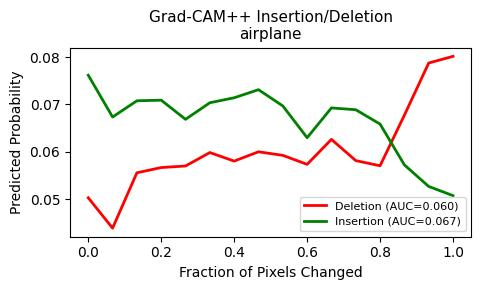

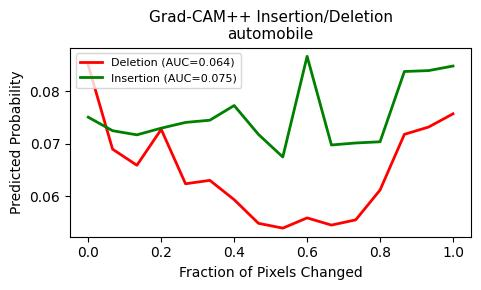

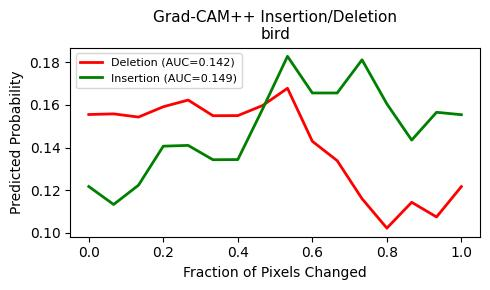

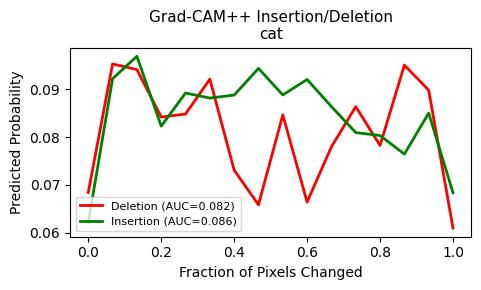

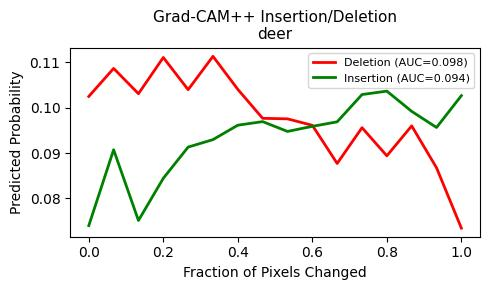

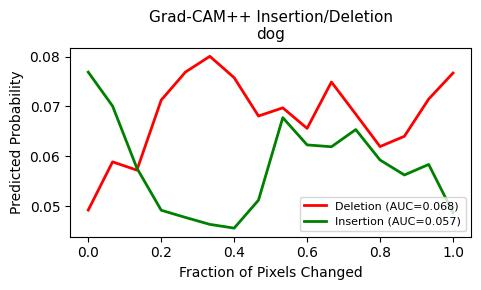

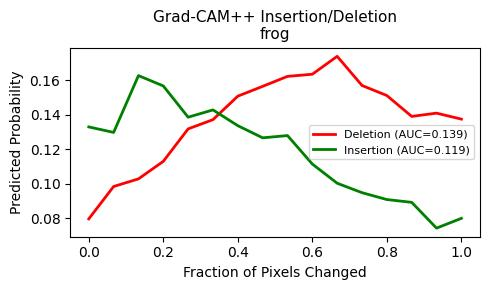

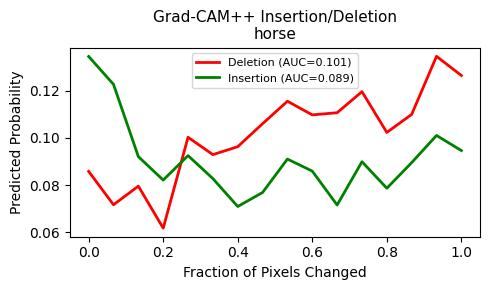

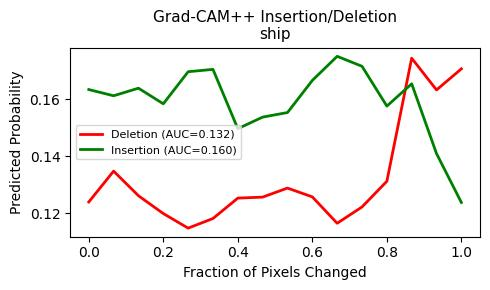

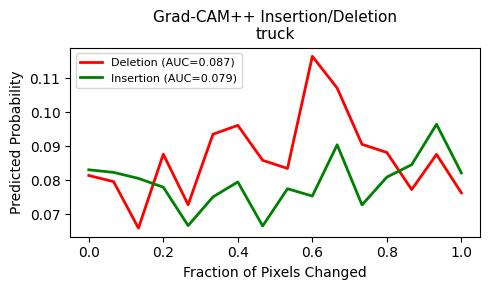


=== Grad-CAM++ AUC Summary ===
airplane        | Insertion AUC: 0.0667 | Deletion AUC: 0.0598
automobile      | Insertion AUC: 0.0751 | Deletion AUC: 0.0636
bird            | Insertion AUC: 0.1492 | Deletion AUC: 0.1416
cat             | Insertion AUC: 0.0858 | Deletion AUC: 0.0822
deer            | Insertion AUC: 0.0936 | Deletion AUC: 0.0984
dog             | Insertion AUC: 0.0575 | Deletion AUC: 0.0685
frog            | Insertion AUC: 0.1190 | Deletion AUC: 0.1390
horse           | Insertion AUC: 0.0895 | Deletion AUC: 0.1012
ship            | Insertion AUC: 0.1603 | Deletion AUC: 0.1316
truck           | Insertion AUC: 0.0793 | Deletion AUC: 0.0874

Mean Insertion AUC: 0.0976
Mean Deletion AUC:  0.0973
Overall Mean AUC:   0.0975


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device).eval()

# --- Define GradCAM++ setup ---
cam = GradCAMPlusPlus(model=model, target_layers=target_layer)

class_names = test_dataset.classes
steps = 15  # reduce slightly for speed


def compute_insertion_deletion_vectorized(model, img_tensor, saliency, img_label, steps=15):
    """Compute insertion & deletion AUC curves for a single image."""
    C, H, W = img_tensor.shape
    img = img_tensor.unsqueeze(0).to(device)

    sal_flat = saliency.flatten()
    indices = np.argsort(-sal_flat)
    step_size = len(indices) // steps
    insertion_masks, deletion_masks = [], []

    for i in range(steps + 1):
        mask_ins = torch.zeros_like(img)
        mask_del = img.clone()

        if i > 0:
            idxs = indices[: i * step_size]
            ys = idxs // W
            xs = idxs % W
            mask_ins[0, :, ys, xs] = img[0, :, ys, xs]
            mask_del[0, :, ys, xs] = 0.0

        insertion_masks.append(mask_ins)
        deletion_masks.append(mask_del)

    insertion_masks = torch.cat(insertion_masks, dim=0)
    deletion_masks = torch.cat(deletion_masks, dim=0)

    with torch.no_grad():
        out_ins = torch.softmax(model(insertion_masks), dim=1)[:, img_label].cpu().numpy()
        out_del = torch.softmax(model(deletion_masks), dim=1)[:, img_label].cpu().numpy()

    return out_ins, out_del


# --- Select 3 images per class ---
images_per_class = {i: [] for i in range(10)}
for idx, lbl in enumerate(test_dataset.targets):
    if len(images_per_class[lbl]) < 3:
        img, _ = test_dataset[idx]
        images_per_class[lbl].append(img)
    if all(len(v) >= 3 for v in images_per_class.values()):
        break


# --- Track AUC values ---
all_auc_ins, all_auc_del = [], []

for cls_idx, imgs in images_per_class.items():
    ins_curves, del_curves = [], []

    for img_tensor in imgs:
        input_tensor = img_tensor.unsqueeze(0).to(device)
        targets = [ClassifierOutputTarget(cls_idx)]

        # GradCAM++ computation (requires gradient)
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

        H, W = img_tensor.shape[1], img_tensor.shape[2]
        saliency_upsampled = cv2.resize(grayscale_cam, (W, H))
        saliency_upsampled = (saliency_upsampled - saliency_upsampled.min()) / (
            saliency_upsampled.max() - saliency_upsampled.min() + 1e-8
        )

        # Insertion/Deletion (no gradient needed)
        ins, dele = compute_insertion_deletion_vectorized(model, img_tensor, saliency_upsampled, cls_idx, steps)
        ins_curves.append(ins)
        del_curves.append(dele)

    ins_mean = np.mean(ins_curves, axis=0)
    del_mean = np.mean(del_curves, axis=0)

    x = np.linspace(0, 1, steps + 1)
    auc_ins = np.trapz(ins_mean, x)
    auc_del = np.trapz(del_mean, x)

    all_auc_ins.append(auc_ins)
    all_auc_del.append(auc_del)

    plt.figure(figsize=(5, 3))
    plt.plot(x, del_mean, label=f'Deletion (AUC={auc_del:.3f})', color='red', linewidth=2)
    plt.plot(x, ins_mean, label=f'Insertion (AUC={auc_ins:.3f})', color='green', linewidth=2)
    plt.title(f"Grad-CAM++ Insertion/Deletion\n{class_names[cls_idx]}", fontsize=11)
    plt.xlabel("Fraction of Pixels Changed")
    plt.ylabel("Predicted Probability")
    plt.legend(fontsize=8)
    plt.tight_layout()
    plt.show()


# --- Print AUC summary ---
print("\n=== Grad-CAM++ AUC Summary ===")
for i, cls_name in enumerate(class_names):
    print(f"{cls_name:15s} | Insertion AUC: {all_auc_ins[i]:.4f} | Deletion AUC: {all_auc_del[i]:.4f}")

mean_ins = np.mean(all_auc_ins)
mean_del = np.mean(all_auc_del)
print(f"\nMean Insertion AUC: {mean_ins:.4f}")
print(f"Mean Deletion AUC:  {mean_del:.4f}")
print(f"Overall Mean AUC:   {(mean_ins + mean_del)/2:.4f}")


In [ ]:
import torch
import numpy as np
import cv2
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# -------------------------------
# Setup
# -------------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device).eval()

target_layer = [model.vit.encoder.layers[-1].ln_1]
cam = GradCAMPlusPlus(model=model, target_layers=target_layer)

class_names = test_dataset.classes


# -------------------------------
# Metric Computation Functions
# -------------------------------
def compute_entropy_sparsity(cam_map):
    """Compute entropy and sparsity of a normalized Grad-CAM++ heatmap."""
    cam_norm = cam_map / (cam_map.sum() + 1e-8)
    entropy = -(cam_norm * np.log(cam_norm + 1e-8)).sum()
    sparsity = 1.0 - (np.count_nonzero(cam_norm > 1e-5) / cam_norm.size)
    return entropy, sparsity


# -------------------------------
# Collect 10 images per class
# -------------------------------
images_per_class = {cls: [] for cls in class_names}

for idx in range(len(test_dataset)):
    img, lbl = test_dataset[idx]
    cls_name = class_names[lbl]
    if len(images_per_class[cls_name]) < 10:
        images_per_class[cls_name].append(img)
    if all(len(v) >= 10 for v in images_per_class.values()):
        break


# -------------------------------
# Compute metrics
# -------------------------------
metrics = {}

for cls_idx, (cls_name, imgs) in enumerate(images_per_class.items()):
    entropies, sparsities = [], []

    for img_tensor in imgs:
        input_tensor = img_tensor.unsqueeze(0).to(device)
        targets = [ClassifierOutputTarget(cls_idx)]

        # Compute GradCAM++ map
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

        # Ensure the map is 2D
        if grayscale_cam.ndim == 3:
            grayscale_cam = np.mean(grayscale_cam, axis=0)

        # Normalize saliency map
        saliency = cv2.resize(grayscale_cam, (img_tensor.shape[2], img_tensor.shape[1]))
        saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min() + 1e-8)

        e, s = compute_entropy_sparsity(saliency)
        entropies.append(e)
        sparsities.append(s)

    metrics[cls_name] = {
        "entropy": np.mean(entropies),
        "sparsity": np.mean(sparsities)
    }


# -------------------------------
# Print results neatly
# -------------------------------
print("\n" + "="*42)
print(f"{'Class':<15s} | {'Entropy':>10s} | {'Sparsity':>10s}")
print("="*42)

all_entropies = []
all_sparsities = []

for cls, vals in metrics.items():
    print(f"{cls:<15s} | {vals['entropy']:.4f} | {vals['sparsity']:.4f}")
    all_entropies.append(vals['entropy'])
    all_sparsities.append(vals['sparsity'])

mean_entropy = np.mean(all_entropies)
mean_sparsity = np.mean(all_sparsities)

print("="*42)
print(f"{'Mean':<15s} | {mean_entropy:.4f} | {mean_sparsity:.4f}")
print("="*42)



Class           |    Entropy |   Sparsity
airplane        | 8.1855 | 0.3629
automobile      | 10.1632 | 0.3948
bird            | 7.3005 | 0.5128
cat             | 7.1946 | 0.5067
deer            | 8.4701 | 0.3744
dog             | 9.1350 | 0.4475
frog            | 8.2634 | 0.4811
horse           | 6.0955 | 0.6188
ship            | 7.4431 | 0.4395
truck           | 8.5343 | 0.3542
Mean            | 8.0785 | 0.4493


**Observations**:

Grad-CAM++ exhibits a behavior similar to Grad-CAM, with slightly lower entropy and sparsity, indicating marginally more structured and focused attributions. However, the overall pattern remains consistent: the method still reflects the tension between localized saliency mechanisms and ViT’s inherently global attention, resulting in non-uniform heatmaps and curve behavior.

## Attention Rollout

**Concept**:

Attention Rollout aggregates attention weight across the transformer layers to visualize how information flows from the input token to the class token.

**Purpose**:

It is used to understand token-level attention propagation and to identify the spatial regions that are strongly integrated by the ViT.

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# =========================
# 1️⃣ Patch MultiheadAttention per block
# =========================
for block in model.vit.encoder.layers:
    attn_module = block.self_attention

    # Save original forward if not saved
    if not hasattr(attn_module, "_original_forward"):
        attn_module._original_forward = attn_module.forward

    # Patch forward method for this module
    def forward_with_attn(self_module, query, key, value, **kwargs):
        # Ensure we get attention weights
        kwargs["need_weights"] = True
        kwargs["average_attn_weights"] = False
        output, attn_weights = self_module._original_forward(query, key, value, **kwargs)
        self_module.attn_output_weights = attn_weights  # store weights
        return output, attn_weights

    # Bind the patched forward to this module
    attn_module.forward = forward_with_attn.__get__(attn_module, attn_module.__class__)

# =========================
# 2️⃣ Define Attention Rollout
# =========================
class AttentionRollout:
    def __init__(self, model, discard_ratio=0.9, head_fusion="mean"):
        self.model = model
        self.discard_ratio = discard_ratio
        self.head_fusion = head_fusion
        self.attentions = []

        # Register hooks to collect attention
        for block in self.model.vit.encoder.layers:
            block.self_attention.register_forward_hook(self._get_attention)

    def _get_attention(self, module, input, output):
        # Grab stored attn weights from the module
        attn = getattr(module, "attn_output_weights", None)
        if attn is not None:
            self.attentions.append(attn)  # keep as is, no detach()
        else:
            self.attentions.append(None)

    def __call__(self, x):
        self.attentions = []
        _ = self.model(x)  # forward pass triggers hooks

        # sanity check
        if not self.attentions or self.attentions[0] is None:
            raise RuntimeError("No attention weights captured. Check forward patch.")

        result = torch.eye(self.attentions[0].size(-1), device=x.device)
        for attention in self.attentions:
            if self.head_fusion == "mean":
                attention_heads_fused = attention.mean(dim=1)
            elif self.head_fusion == "max":
                attention_heads_fused = attention.max(dim=1)[0]
            else:
                raise ValueError("Unknown head_fusion")

            # Drop low attention values
            flat = attention_heads_fused.view(-1)
            _, indices = flat.topk(int(flat.size(0) * (1 - self.discard_ratio)), largest=False)
            flat[indices] = 0
            attention_heads_fused = flat.view(attention_heads_fused.size())

            result = torch.matmul(attention_heads_fused, result)

        return result

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def plot_vit_rollout_top(rollout, image_tensor, image_size=(32,32), top_percent=0.2):
    x = image_tensor.unsqueeze(0)
    mask = rollout(x)

    # CLS token attention to patches
    mask_no_cls = mask[0, 0, 1:]

    # take only top_percent attention
    k = int(len(mask_no_cls) * top_percent)
    threshold, _ = torch.kthvalue(mask_no_cls, len(mask_no_cls)-k)
    mask_no_cls = torch.where(mask_no_cls >= threshold, mask_no_cls, torch.zeros_like(mask_no_cls))

    # normalize
    mask_no_cls = mask_no_cls / (mask_no_cls.max() + 1e-8)

    # reshape to square
    side = int(mask_no_cls.numel() ** 0.5 + 0.5)
    pad = side*side - mask_no_cls.numel()
    if pad > 0:
        mask_no_cls = torch.cat([mask_no_cls, torch.zeros(pad, device=mask_no_cls.device)])
    mask_2d = mask_no_cls.reshape(1, 1, side, side)

    # interpolate
    mask_img = F.interpolate(mask_2d, size=image_size, mode='bilinear', align_corners=False)[0,0].detach().cpu().numpy()

    # plot
    plt.imshow(image_tensor.permute(1,2,0).cpu().numpy())
    plt.imshow(mask_img, cmap='jet', alpha=0.5)
    plt.axis("off")
    plt.show()


In [ ]:
rollout = AttentionRollout(model.to(device))

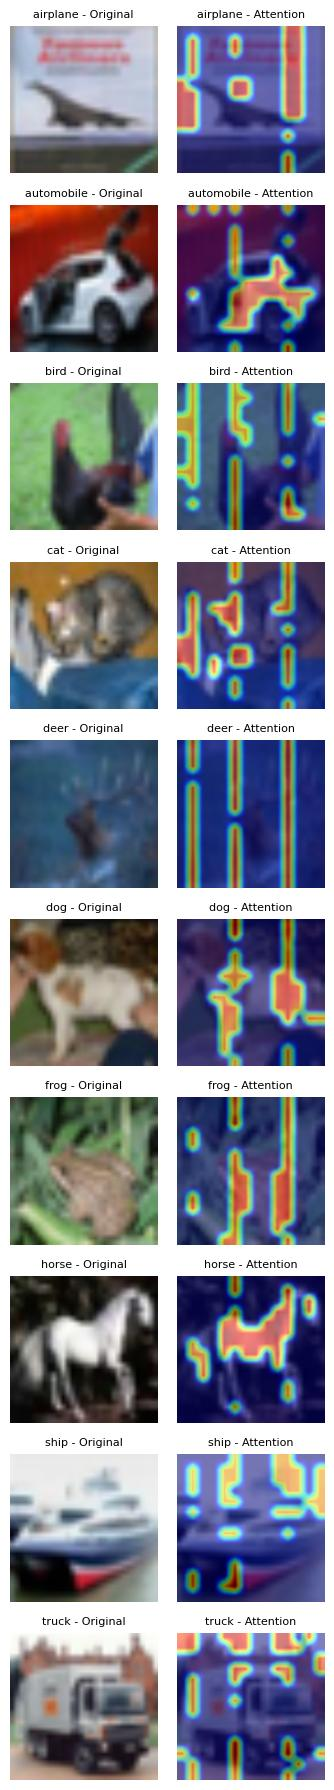

In [ ]:
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


classes = testset.classes  # ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

# --- Function to pick 1 image per class ---
def get_one_per_class(dataset):
    samples = {}
    for img, label in dataset:
        cls_name = classes[label]
        if cls_name not in samples:  # take only the first occurrence
            samples[cls_name] = img
        if len(samples) == len(classes):
            break
    return samples

samples = get_one_per_class(testset)

# --- Plot both original and attention side-by-side ---
fig, axes = plt.subplots(10, 2, figsize=(4, 18))  # smaller overall figure
plt.subplots_adjust(wspace=0.2, hspace=0.6)  # tighter spacing

for i, cls_name in enumerate(classes):
    img = samples[cls_name].to(device)
    x = img.unsqueeze(0)

    # Run attention rollout
    mask = rollout(x)
    mask_no_cls = mask[0, 0, 1:]

    # Keep top 20% attention
    k = int(len(mask_no_cls) * 0.2)
    threshold, _ = torch.kthvalue(mask_no_cls, len(mask_no_cls) - k)
    mask_no_cls = torch.where(mask_no_cls >= threshold, mask_no_cls, torch.zeros_like(mask_no_cls))

    # Normalize and reshape
    mask_no_cls = mask_no_cls / (mask_no_cls.max() + 1e-8)
    side = int(mask_no_cls.numel() ** 0.5 + 0.5)
    pad = side * side - mask_no_cls.numel()
    if pad > 0:
        mask_no_cls = torch.cat([mask_no_cls, torch.zeros(pad, device=mask_no_cls.device)])
    mask_2d = mask_no_cls.reshape(1, 1, side, side)

    # Interpolate to match image size
    mask_img = F.interpolate(mask_2d, size=(224, 224), mode="bilinear", align_corners=False)[0, 0].detach().cpu().numpy()

    # --- Original Image ---
    axes[i, 0].imshow(img.permute(1, 2, 0).cpu().numpy())
    axes[i, 0].set_title(f"{cls_name} - Original", fontsize=8)
    axes[i, 0].axis("off")

    # --- Attention Map ---
    axes[i, 1].imshow(img.permute(1, 2, 0).cpu().numpy())
    axes[i, 1].imshow(mask_img, cmap="jet", alpha=0.5)
    axes[i, 1].set_title(f"{cls_name} - Attention", fontsize=8)
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()


**Observations**:

Attention Rollout's visualization reflects the patch-token structure of the ViT architecture resulting in line-like saliency patterns instead of blob-like activations. This highlights the discrete, token-level reasoning mechanism that is inherent to the transformer architecture.

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Insertion / Deletion metric (minimal version)
def insertion_deletion(model, image, saliency, label, steps=50, mode="deletion"):
    """
    model   : your trained model
    image   : single image tensor (C, H, W)
    saliency: explanation heatmap (H, W), normalized [0,1]
    label   : target class index (int)
    steps   : number of points in the curve
    mode    : "deletion" or "insertion"
    """
    model.eval()
    device = next(model.parameters()).device

    # ensure shapes
    image = image.unsqueeze(0).to(device)  # (1, C, H, W)
    saliency = saliency.detach().cpu().numpy()

    H, W = saliency.shape
    N = H * W

    # Flatten saliency and sort pixels by importance
    flat = saliency.flatten()
    idxs = np.argsort(-flat)  # most important first

    # Create baseline image
    if mode == "deletion":
        img = image.clone()
    else:  # insertion starts from a blurred/gray image
        img = torch.zeros_like(image)

    probs = []
    step_size = N // steps

    for i in range(0, N, step_size):
        if mode == "deletion":
            # mask out top-k important pixels
            for j in idxs[i:i+step_size]:
                y, x = divmod(j, W)
                img[0, :, y, x] = 0
        else:
            # reveal top-k important pixels
            for j in idxs[i:i+step_size]:
                y, x = divmod(j, W)
                img[0, :, y, x] = image[0, :, y, x]

        with torch.no_grad():
            out = model(img)
            prob = torch.softmax(out, dim=1)[0, label].item()
        probs.append(prob)

    return probs



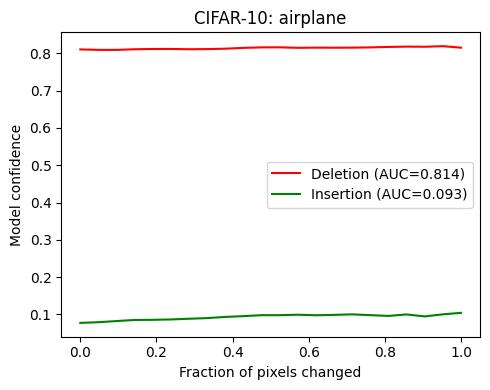

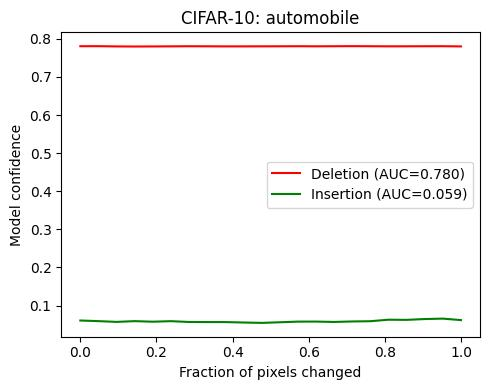

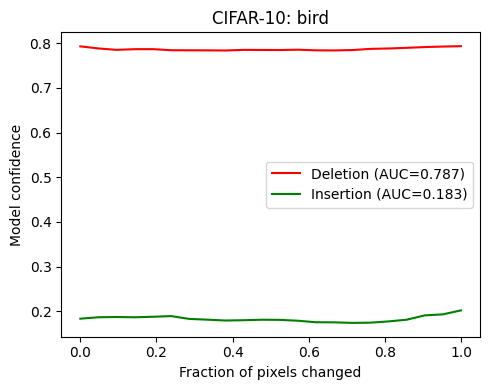

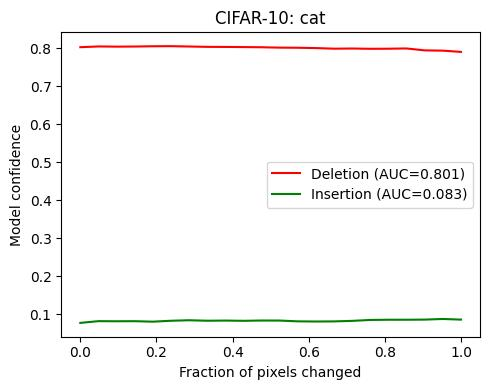

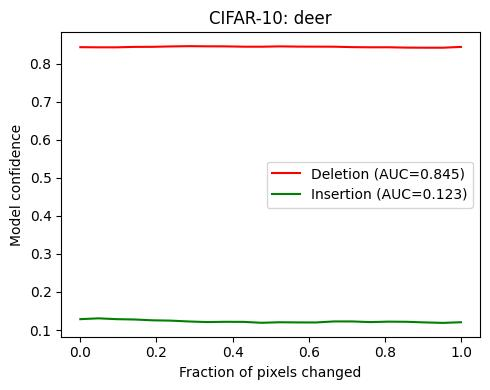

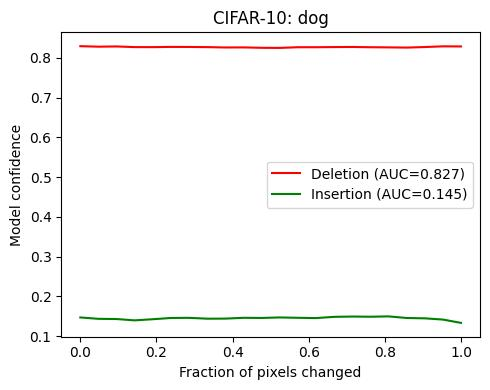

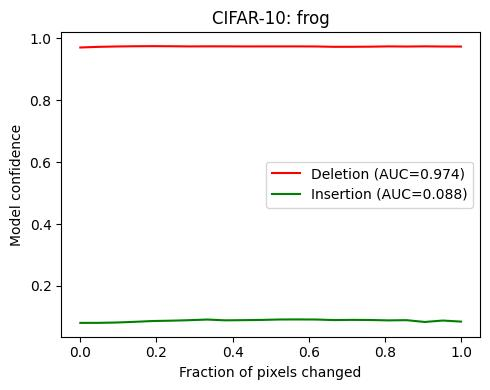

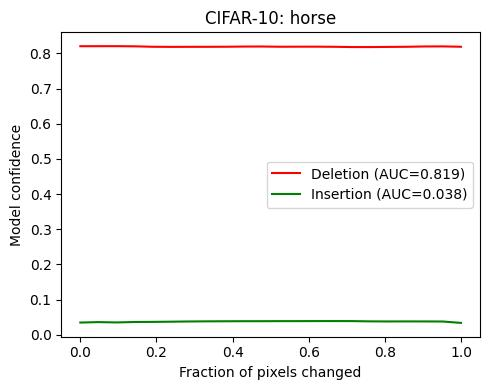

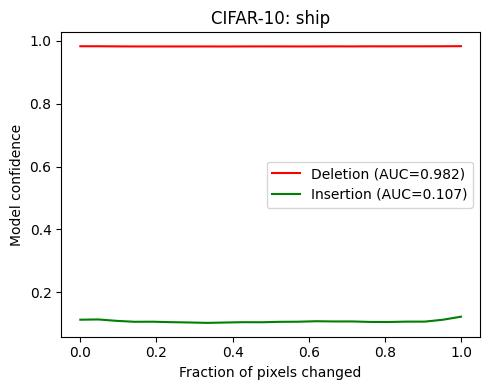

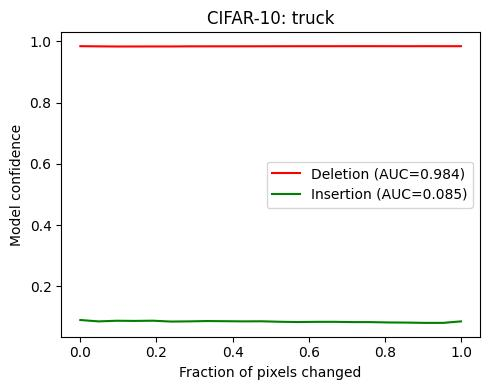


Class           |    Del AUC |    Ins AUC
airplane        |     0.8143 |     0.0931
automobile      |     0.7803 |     0.0588
bird            |     0.7866 |     0.1826
cat             |     0.8007 |     0.0827
deer            |     0.8445 |     0.1227
dog             |     0.8270 |     0.1454
frog            |     0.9741 |     0.0880
horse           |     0.8190 |     0.0376
ship            |     0.9824 |     0.1070
truck           |     0.9835 |     0.0846
Mean            |     0.8612 |     0.1003


In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

device = "cuda" if torch.cuda.is_available() else "cpu"

# ------------------ PARAMETERS ------------------
steps = 20          # points in insertion/deletion curve
num_per_class = 10  # number of test images per class

# Store results per class
class_probs_del = defaultdict(list)
class_probs_ins = defaultdict(list)

# CIFAR-10 class names
classes = ['airplane','automobile','bird','cat','deer',
           'dog','frog','horse','ship','truck']

# ------------------ LOOP THROUGH TEST DATA ------------------
class_counts = defaultdict(int)
for img, lbl in test_loader:
    img, lbl = img.to(device), lbl.to(device)

    for i in range(len(lbl)):
        c = lbl[i].item()
        if class_counts[c] >= num_per_class:
            continue  # already enough for this class

        # --- Generate heatmap using Attention Rollout ---
        saliency = rollout(img[i].unsqueeze(0))
        mask_no_cls = saliency[0, 0, 1:]
        side = int(mask_no_cls.numel() ** 0.5 + 0.5)
        saliency_2d = mask_no_cls.reshape(side, side)
        saliency_2d = saliency_2d / (saliency_2d.max() + 1e-8)

        # --- Compute Deletion and Insertion Curves ---
        probs_del = insertion_deletion(model, img[i], saliency_2d, c, steps=steps, mode="deletion")
        probs_ins = insertion_deletion(model, img[i], saliency_2d, c, steps=steps, mode="insertion")

        class_probs_del[c].append(probs_del)
        class_probs_ins[c].append(probs_ins)

        class_counts[c] += 1

    # stop if all classes filled
    if all([class_counts[i] >= num_per_class for i in range(10)]):
        break

# ------------------ AVERAGE, AUC, AND PLOT ------------------
auc_del_all, auc_ins_all = [], []

for c in range(10):
    avg_del = np.mean(class_probs_del[c], axis=0)
    avg_ins = np.mean(class_probs_ins[c], axis=0)

    x_axis = np.linspace(0, 1, len(avg_del))

    # Compute AUCs
    auc_del = np.trapz(avg_del, x_axis)
    auc_ins = np.trapz(avg_ins, x_axis)
    auc_del_all.append(auc_del)
    auc_ins_all.append(auc_ins)

    # Plot curves with AUCs displayed
    plt.figure(figsize=(5, 4))
    plt.plot(x_axis, avg_del, label=f"Deletion (AUC={auc_del:.3f})", color='red')
    plt.plot(x_axis, avg_ins, label=f"Insertion (AUC={auc_ins:.3f})", color='green')
    plt.title(f"CIFAR-10: {classes[c]}")
    plt.xlabel("Fraction of pixels changed")
    plt.ylabel("Model confidence")
    plt.legend()
    plt.tight_layout()
    plt.show()

# ------------------ PRINT SUMMARY ------------------
print("\n" + "="*50)
print(f"{'Class':<15} | {'Del AUC':>10} | {'Ins AUC':>10}")
print("="*50)
for c in range(10):
    print(f"{classes[c]:<15} | {auc_del_all[c]:>10.4f} | {auc_ins_all[c]:>10.4f}")
print("="*50)
print(f"{'Mean':<15} | {np.mean(auc_del_all):>10.4f} | {np.mean(auc_ins_all):>10.4f}")
print("="*50)


**Observations**:

The flat Insertion and Deletion curves suggests that the line-like structures highlighted by Attention Rollout does not affect the model's confidence because they're not class-discriminative evidences. Instead, they represent the flow of attention across tokens, consistent with the transformer's global reasoning mechasnism.



In essence, the highlighted, line-like regions in the Attention Rollout maps represent patches that are strongly engaged in information exchange with other patches across the transformer layers. These highlighted regions act as high-traffic communication routes in the model’s reasoning process.

 Conversely, the dim or unhighlighted areas indicate patches that have a weaker participation in the global attention flow, thereby contributing less to the overall decision.


 This suggests that raw Attention alone cannot be a faithful explanation of model reasoning because it captures connectivity strength and not spatial importance.



In [ ]:
import torch
import numpy as np
import torch.nn.functional as F

def attention_entropy_sparsity_full(rollout, dataset, device, num_classes=10, samples_per_class=10):
    """
    Compute entropy & sparsity for attention rollout across all CIFAR-10 classes.
    Selects `samples_per_class` images per class automatically.
    """
    entropy_per_class = [[] for _ in range(num_classes)]
    sparsity_per_class = [[] for _ in range(num_classes)]

    # --- Collect 10 images per class ---
    images_per_class = {i: [] for i in range(num_classes)}
    for img, lbl in dataset:
        if len(images_per_class[lbl]) < samples_per_class:
            images_per_class[lbl].append(img)
        if all(len(v) >= samples_per_class for v in images_per_class.values()):
            break

    # --- Compute metrics ---
    for cls_idx, imgs in images_per_class.items():
        for img in imgs:
            x = img.unsqueeze(0).to(device)
            mask = rollout(x)  # shape: (1, num_tokens, num_tokens)

            # CLS token → patch attention
            attn = mask[0, 0, 1:].detach()
            attn = attn / (attn.sum() + 1e-8)

            # Entropy
            entropy = -(attn * torch.log(attn + 1e-8)).sum().item()

            # Sparsity: fraction of low-attention elements
            sparsity = (attn < 1e-3).float().mean().item()

            entropy_per_class[cls_idx].append(entropy)
            sparsity_per_class[cls_idx].append(sparsity)

    # --- Compute means ---
    entropy_mean = [np.mean(e) for e in entropy_per_class]
    sparsity_mean = [np.mean(s) for s in sparsity_per_class]

    # --- Print neatly ---
    print("\n" + "="*46)
    print(f"{'Class':<15s} | {'Entropy':>10s} | {'Sparsity':>10s}")
    print("="*46)
    for i in range(num_classes):
        print(f"{dataset.classes[i]:<15s} | {entropy_mean[i]:10.4f} | {sparsity_mean[i]:10.4f}")
    print("="*46)
    print(f"{'Mean':<15s} | {np.mean(entropy_mean):10.4f} | {np.mean(sparsity_mean):10.4f}")
    print("="*46)

    return entropy_mean, sparsity_mean


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

entropy_mean, sparsity_mean = attention_entropy_sparsity_full(
    rollout=rollout,        # the trained AttentionRollout object
    dataset=testset,        # CIFAR-10 test dataset
    device=device,
    samples_per_class=10
)



Class           |    Entropy |   Sparsity
airplane        |     5.2144 |     0.0408
automobile      |     5.2159 |     0.0250
bird            |     5.2132 |     0.0316
cat             |     5.2083 |     0.0316
deer            |     5.1929 |     0.0577
dog             |     5.2066 |     0.0367
frog            |     5.2017 |     0.0408
horse           |     5.2093 |     0.0327
ship            |     5.2078 |     0.0429
truck           |     5.2109 |     0.0357
Mean            |     5.2081 |     0.0376


**Observations:**

The very low Sparsity indicates that only a tiny subset of patches are strongly activated in the Attention Rollout maps. This is a reflection of rollout mechanism as it condenses multiple attention layers into a few dominant communication paths across the tokens.

The moderate Entropy indicates that, within these few active connections, the attention is moderately spread and not completely concentrated on one token, but it's not fully uniform either because the Entropy value isn't low.

This suggests that Attention Rollout highlights stable, global communication routes instead of spatially detailed, class-specific regions. This aligns well with the transformer’s global reasoning mechanism, where a small number of high-attention tokens aggregate contextual information from the entire image.